# Error correction with cat qubits

A central obstacle to building useful quantum computers is the prevalence of hardware-level noise, which corrupts quantum information long before meaningful computations can be completed. Quantum error correction addresses this challenge by encoding a single logical qubit across many noisy physical qubits, allowing errors to be detected and corrected without destroying the encoded information.

Dissipative cat qubits encode one logical qubit in the phase space of a quantum harmonic oscillator, also known as a bosonic mode. As the average photon number increases, the phase-flip error rate of a cat qubit can be suppressed exponentially, while the bit-flip error rate grows only linearly [[REF](https://arxiv.org/pdf/1907.11729)]. This asymmetry enables access to regimes of strong noise bias, where phase-flip errors can, in principle, be made arbitrarily rare, leaving bit-flip errors as the dominant remaining failure mode.

This noise bias can be exploited by concatenating cat qubits with higher-level quantum error-correcting codes that are optimized to suppress bit-flip errors. The result is a substantial reduction in the number of physical resources required to achieve fault-tolerant quantum computation, compared to architectures based on unbiased qubits.

In this challenge, you will explore how cat qubits enable significant reductions in hardware overhead for fault-tolerant quantum computing. You will also investigate novel error-correcting codes that are particularly well suited for concatenation with cat qubits, further reducing complexity and resource requirements.

**NOTE:** All subtasks in this notebook are marked with `[TODO]`. You can use Ctrl/Cmd+F to find them and make sure you do not miss any. In some places, you will also see sections labeled `# SOLUTION ===`, which indicate where you should add code to complete the task.

# 1 - Installations


Begin by uncommenting and running the cell below to install the dependencies needed for this challenge.

In [267]:
import stim
import pymatching
import sinter
from typing import List
import matplotlib.pyplot as plt
import os 
import numpy as np


print(stim.__version__)

1.15.0


# 2 - Bell states & Error Detection Codes

The following section demonstrates the creation and measurement of a bell state:

$$ \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

Then, we will use bell states as codewords for the smallest error detection code.

In [268]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

H 0
CX 0 1
M 0 1

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-



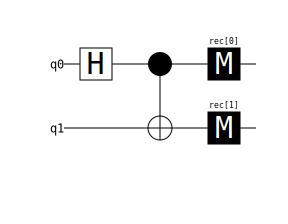

In [269]:
print(circuit)
print("")
print(circuit.diagram())
print("")
circuit.diagram('timeline-svg')

Now, we can sample this circuit and, in doing so, measure the state of each qubit.

In [270]:
sampler = circuit.compile_sampler()
sampler.sample(shots=10)

array([[False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False]])

Here, False means 0 and True means 1. Notice how the results of the measurement qubit 0 and the measurement on qubit 1 always match, as expected of a bell state. So, we can expect a parity measurement between the two qubits to always be 0, since the two qubits will always have the same state. In stim, the parity is measured using a "DETECTOR" operation, as shown below:

In [271]:
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


In [272]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


Now, let's add X errors onto each qubit.

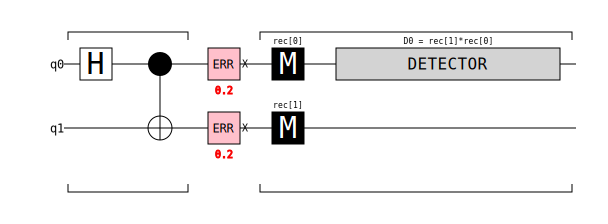

In [11]:
p = 0.2
circuit = stim.Circuit(f"""
    H 0
    CX 0 1
    
    TICK
    X_ERROR({p}) 0 1
    TICK

    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

circuit.diagram('timeline-svg')

In [12]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [False]
 [ True]
 [ True]
 [ True]]


With stim, we can quickly collect many samples, extracting the detector hit rate, which should be:

$$p*(1-p)*2$$

In [13]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)
print(p*(1-p)*2)

0.319962
0.32000000000000006


## Task 2.1: Error detection code

[TODO, 10pts]: As shown, in the absence of noise the parity between the two qubits in a Bell state is fixed.

The presence of a single-qubit bit-flip error changes this parity, which appears as a nonzero detector outcome when the stabilizer $Z_0 Z_1$ is measured. This observation can be used to construct the simplest quantum error-detecting code, the two-qubit code $[[2,1,1]]$. In the notation $[[n,k,d]]$, $n$ is the number of physical qubits, $k$ is the number of logical qubits, and $d$ is the code distance. The distance $d$ is the minimum weight of a Pauli operator that preserves the codespace while acting nontrivially on the logical information.

You will now implement a $[[2,1,1]]$ code using two data qubits and one ancilla qubit to measure the stabilizer $Z_0 Z_1$. A convenient choice of logical basis states within the codespace is

$$
\ket{0_L} = \ket{\Phi^+} = \frac{\ket{00} + \ket{11}}{\sqrt{2}}, \qquad
\ket{1_L} = \ket{\Phi^-} = \frac{\ket{00} - \ket{11}}{\sqrt{2}}.
$$

Assume that each data qubit undergoes an independent $X$ error with probability $p = 0.1$. An odd number of bit flips anticommutes with $Z_0 Z_1$ and is therefore detected by the parity check. By postselecting on runs with a trivial detector outcome (i.e. detector = False), all such odd-parity leakage error events are removed. These are denoted leakage errors, as they the qubits out of the codespace, spanned by superpositions of the codewords. 


As a result, postselection suppresses all first-order physical bit-flip errors. The only remaining error process on the accepted runs is the even-parity event $X_0 X_1$, which is a logical identity operator as both codewords are in its +1 eigenbasis. 

Set up this code, simulate it with X errors on each data qubit after the preparation of a bell state, and show that leakage errors and logical errors are fully suppressed with postselection on no detector events. Calculate the success probability of no detector errors occurring as a function of the physical error rate $p$ and show that it matches your simulation.

In [273]:
# SOLUTION ===
# initialize stim circuit needed for this simulation
circuit = stim.Circuit("""
    H 0
    CX 0 1
    
    TICK
    X_ERROR(0.1) 0 1
    TICK

    CX 0 2
    CX 1 2
    M 2
    DETECTOR rec[-1]
""")
# ===

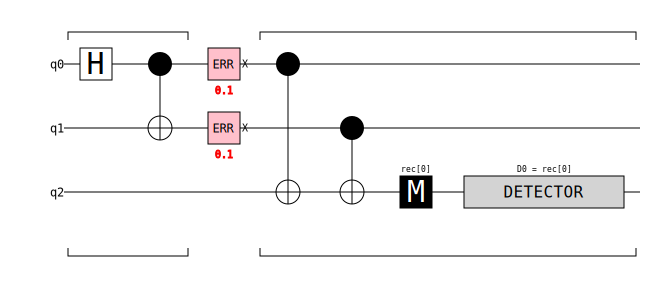

In [274]:
circuit.diagram('timeline-svg')

In [275]:
# SOLUTION ===
# run/sample simulation to calculated a simulated logical error rate
sampler = circuit.compile_detector_sampler()
simulated_logical_error_rate = np.sum(sampler.sample(shots=10**6)) / 10**6
# ===

In [276]:
p = 0.1
success_prob = 1 - p*(1-p)*2
print("success probability:", success_prob, simulated_logical_error_rate)

success probability: 0.82 0.179507


# 3 - Repetition Code

## Task 3.1 Implement a decoder for the repetition code.

[TODO, 5pts]: You will now implement and simulate the $n$-qubit repetition code with asymmetric distance $[[n,1,d_X=n,d_Z=1]]$, defined by the logical codewords

$$
\ket{0_L} = \ket{000\cdots 0}, \qquad 
\ket{1_L} = \ket{111\cdots 1}.
$$

The stabilizer group is generated by the $n-1$ nearest-neighbor parity checks

$$
Z_i Z_{i+1}, \qquad i = 0, \dots, n-2 .
$$

These stabilizers extract $n-1$ independent bits of syndrome information, leaving exactly one protected logical degree of freedom. In other words, the code encodes a single logical qubit into $n$ physical qubits. A convenient choice of logical operators is

$$
X_L = X_0 X_1 \cdots X_{n-1}, \qquad Z_L = Z_0 \ \ (\text{equivalently any } Z_i),
$$

so the code has $X$-distance $d_X=n$ (it protects against bit-flip errors up to weight $\lfloor (n-1)/2\rfloor$) but only $Z$-distance $d_Z=1$.

Your first task is to implement a decoder that takes as input a final measurement of all data qubits together with a single round of stabilizer measurements, and outputs the most likely logical state. Rather than using a simple majority-vote rule, your decoder should explicitly use the stabilizer syndromes to infer a most likely correction consistent with the observed syndrome, apply that correction to the final data-qubit measurements, and then determine the decoded logical value. This approach is more scalable to real-time quantum error correction, where stabilizer measurements can be used to decode errors and apply corrections during an algorithm to recover back to the codespace and protect logical information.

*Note: For codes used with biased physical noise, it is often useful to specify separate distances $d_X$ (the minimum weight nontrivial logical $X$ operator) and $d_Z$ (the minimum weight nontrivial logical $Z$ operator), rather than quoting a single distance $d=\min(d_X,d_Z)$.


In [277]:
from typing import Tuple

def decode_repetition_code(
    meas: Tuple[str, str],
) -> int:

    """
    Decode an n-qubit classical repetition code (bit-flip code).

    Args:
        meas: (data_bits, stabilizer_bits)
            - data_bits: length-n string like "001" (final Z-basis measurements of data qubits)
            - stabilizer_bits: length-(n-1) string like "01" (parity checks between neighbors),
              typically s_i = data_bits[i] XOR data_bits[i+1], ordered left-to-right.
              This input is accepted but not required for majority decoding.

    Returns:
        0 or 1: decoded logical state.
    """

    # SOLUTION ===
    data_str, stabilizer_str = meas
    n = len(data_str)
    data = [int(bit) for bit in data_str]
    stabilizer = [int(bit) for bit in stabilizer_str]

    rel_error = [0] * n
    current_parity = 0
    
    for i in range(n - 1):
        if stabilizer[i] == 1:
            # A syndrome of 1 means the parity flipped between i and i+1
            current_parity = 1 - current_parity
        rel_error[i + 1] = current_parity

    weight_0 = sum(rel_error)                 
    weight_1 = n - weight_0                 

    correction = []
    if weight_0 <= weight_1:
        correction = rel_error
    else:
        correction = [1 - x for x in rel_error]

    corrected_data = [(data[i] + correction[i]) % 2 for i in range(n)]

    def binary_majority_vote(arr: np.array):
        return 1 if np.mean(arr) > 0.5 else 0
    
    return binary_majority_vote(corrected_data)
    

In [278]:
print(decode_repetition_code(("00011", "0010")))

0


## Task 3.2 - Simulate logical error rates

[TODO, 5pts]: Now, set up stim circuits to prepare logical $\ket{0_L}$ or $\ket{1_L}$. This circuit should contain $n$ data qubits and $n-1$ measure qubits that are used to measure parity between neighboring data qubits. Then, insert X errors on the data qubits with probability $p$ after initializing qubits to logical $\ket{0_L}$ or $\ket{1_L}$, measure the parity stabilizers $Z_{i}Z_{i+1}$ with measure qubits, and finally measure the state of each data qubit. 

Then, using your decoder, decode what the logical state should be for each possible scenario. The ratio of when you decoded incorrectly over the total number of shots is your logical error probability $p_L$. 

Make a plot of $p_L$ vs physical error probability (sampled logarithmically) $p \in [0.1, 0.5]$ for $n \in [3,5,7,9]$. Both axes in this plot should be on a log scale. At what value of $p$ do you see a threshold, the point where increasing $n$ helps to suppress logical errors? 

In [279]:
# e.g. 3-qubit rep code

circuit = stim.Circuit('''
    R 0 1 2 3 4

    TICK
    X_ERROR(0.1) 0 2 4

    TICK
    CX 0 1 2 3
    
    TICK
    CX 2 1 4 3
    
    TICK
    MR 1 3
    
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]

    TICK
    M 0 2 4
    OBSERVABLE_INCLUDE(0) rec[-3]
    OBSERVABLE_INCLUDE(1) rec[-2]
    OBSERVABLE_INCLUDE(2) rec[-1]
''')

In [280]:
# generalized rep code

def repetition_code_circuit(n: int, p: float = 0.1) -> stim.Circuit:
    """
    Build an n-qubit repetition code circuit using a Stim string.

    Layout:
      data qubits:   0, 2, 4, ..., 2(n-1)
      ancilla qubits: 1, 3, 5, ..., 2(n-2)+1

    Total qubits: 2n-1
    """

    # SOLUTION ===
    circuit = stim.Circuit()
    
    # initialization
    circuit.append("R", range(2 * n - 1))
    circuit.append("TICK")
    
    # apply X error 
    data_qubits = [2 * i for i in range(n)]
    circuit.append("X_ERROR", data_qubits, p)
    circuit.append("TICK")
    
    # measure syndrome
    # Data[i] + Ancilla[i]
    pair_1 = []
    for i in range(n - 1):
        pair_1.extend([2 * i, 2 * i + 1])
    circuit.append("CX", pair_1)
    circuit.append("TICK")
    
    # Data[i+1] + Ancilla[i]
    pair_2 = []
    for i in range(n - 1):
        pair_2.extend([2 * (i + 1), 2 * i + 1])
    circuit.append("CX", pair_2)
    circuit.append("TICK")
    
    # Measure Ancillas 
    ancilla_qubits = [2 * i + 1 for i in range(n - 1)]
    circuit.append("M", ancilla_qubits)
    
    # Measure Data qubits
    circuit.append("M", data_qubits)

    for i in range(n - 1):
        rec_index = stim.target_rec(-n - (n - 1) + i)
        circuit.append("DETECTOR", [rec_index], [i, 0])

    circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-n)], 0)
    
    return circuit
    # ===


def simulate_circuit(circuit, n, num_shots=100_000):
    """ 
    Simulate the circuit and return the results.

    Args:
        circuit: The circuit to simulate.
        n: The number of data qubits.

    Returns:
        results: {(data_bits, stabilizer_bits): counts}
    """

    # SOLUTION ===
    sampler = circuit.compile_sampler()
    samples = sampler.sample(shots=num_shots)
    
    results = {}
    for row in samples:
        stab_bits = "".join(str(int(b)) for b in row[:n-1])
        data_bits = "".join(str(int(b)) for b in row[n-1:])
        
        key = (data_bits, stab_bits)
        if key in results:
            results[key] += 1
        else:
            results[key] = 1
            
    return results
    # ===

def logical_error_rate(
    results: dict[tuple[str, str], int],
    logical_prepared: int = 0,
) -> float:
    """
    Compute logical error rate using decode_repetition_code.

    Args:
        results: {(data_bits, stabilizer_bits): counts}
        logical_prepared: 0 or 1 logical state that was prepared.

    Returns:
        Logical error probability.
    """

    # SOLUTION ===
    total_shots = sum(results.values())
    incorrect_counts = 0
    
    for (data_str, stab_str), count in results.items():
        decoded_state = decode_repetition_code((data_str, stab_str))
        if decoded_state != logical_prepared:
            incorrect_counts += count
            
    return incorrect_counts / total_shots
    # ===


def run_sim(n, p):
    circuit = repetition_code_circuit(n, p=p)
    results = simulate_circuit(circuit, n)
    return logical_error_rate(results, logical_prepared=0)

In [281]:
# Example
n = 3
p = 0.2
circuit = repetition_code_circuit(n, p=p)

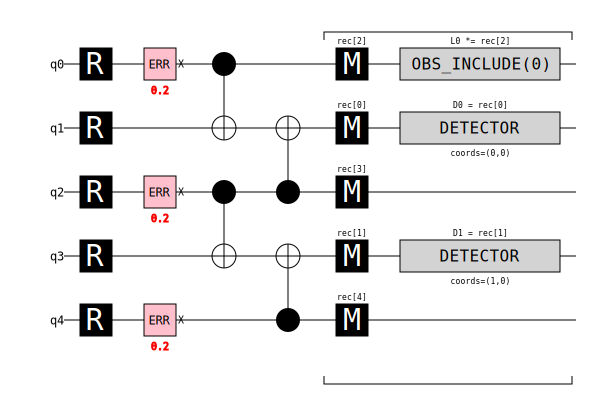

In [282]:
circuit.diagram('timeline-svg')

In [283]:
results = simulate_circuit(circuit, n)
results

{('000', '00'): 51304,
 ('100', '10'): 12647,
 ('010', '11'): 12878,
 ('001', '01'): 12844,
 ('110', '01'): 3094,
 ('011', '10'): 3236,
 ('101', '11'): 3235,
 ('111', '00'): 762}

In [284]:
print(logical_error_rate(results, logical_prepared=0))

prob_two_error = 3 * (1-p) * p * p
prob_three_error = p * p * p
sim_logical_error_rate = prob_two_error + prob_three_error

print(sim_logical_error_rate)

0.10327
0.10400000000000004


In [285]:
error_probabilities = np.logspace(-1, np.log10(0.5), 21)
distances = [3, 5, 7, 9]
data_results = {d: [] for d in distances}

# SOLUTION ===
# collect simulation data for varying distances and error_probabilities
for n in distances:
    for p in error_probabilities:
        circuit = repetition_code_circuit(n, p=p)
        results = simulate_circuit(circuit, n, num_shots=20_000)
        p_L = logical_error_rate(results, logical_prepared=0)
        data_results[n].append(p_L)
# ===

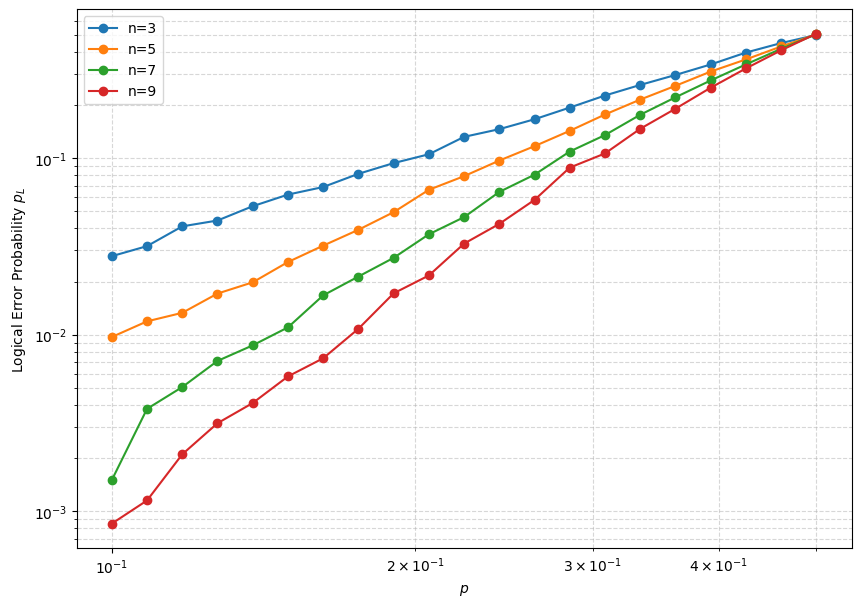

In [286]:
# SOLUTION ===
# plot results
plt.figure(figsize=(10, 7))

for n in distances:
    plt.plot(error_probabilities, data_results[n], 'o-', label=f'n={n}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p$')
plt.ylabel('Logical Error Probability $p_L$')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()
# ===

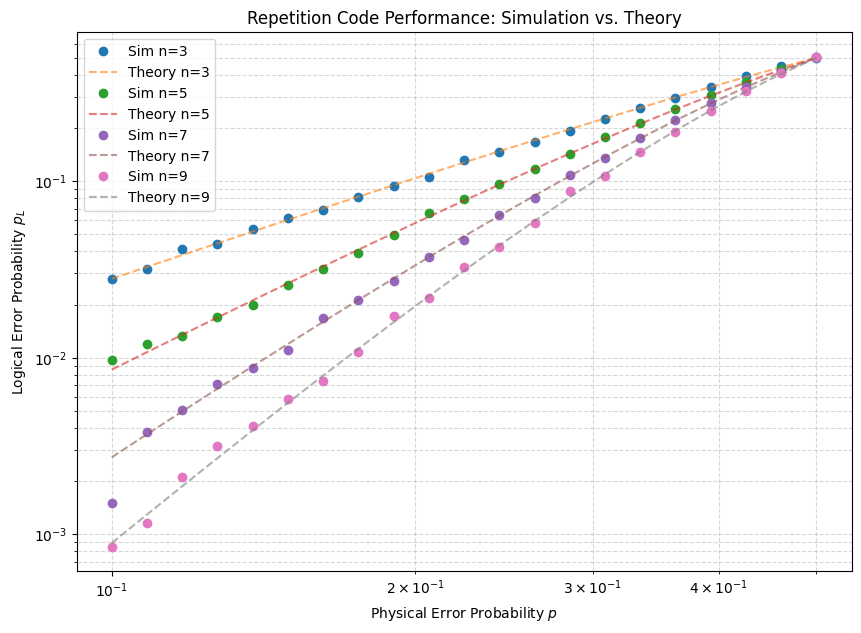

In [288]:
from scipy.special import comb

def get_theoretical_pL(p, n):
    """Calculates the theoretical logical error rate for distance n."""
    threshold = (n + 1) // 2
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(threshold, n + 1))

plt.figure(figsize=(10, 7))

for n in distances:
    plt.plot(error_probabilities, data_results[n], 'o', label=f'Sim n={n}')
    
    theory_pL = [get_theoretical_pL(p, n) for p in error_probabilities]
    plt.plot(error_probabilities, theory_pL, '--', alpha=0.6, label=f'Theory n={n}')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Physical Error Probability $p$')
plt.ylabel('Logical Error Probability $p_L$')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.title("Repetition Code Performance: Simulation vs. Theory")
plt.legend()
plt.show()

# 4 - Compare surface code vs cat-repetition code

In this section, we will benchmark the cat-repetition code against a conventional surface code built from unbiased qubits. While the surface code is designed to protect against general, symmetric noise, the cat-repetition code is optimized for a strongly biased error channel in which phase flips are exponentially suppressed and bit flips dominate. By comparing these two architectures under their respective noise models, we can directly evaluate the advantages of exploiting hardware bias. We will focus on resource efficiency, logical error rates, and scaling with system size to highlight when and why a bias-tailored code can outperform a more general-purpose quantum error correcting code.

Here is an especially useful resource for this section: 
[https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb](https://github.com/quantumlib/Stim/blob/main/doc/getting_started.ipynb)

Please feel free to adapt code from the above notebook. The point of the tasks in this section is to explore logical error rates and hardware resource overheads in different parameter regimes, not figure out syntax.

## Task 4.1 - cat-repetition code threshold

Since cat qubits can exponentially suppress phase-flip errors, the dominant remaining noise channel is bit flips on the encoded qubits. In this task, you will study how the logical error rate scales with the number of cat qubits used as data qubits in a repetition code, assuming each data qubit experiences a fixed bit-flip error rate.

[TODO, 2.5pts]: First, complete `generate_rep_code_bit_flips` to return a repetition-code memory circuit with distance `d`, `3d` rounds, and bit-flip noise applied as `X_ERROR(noise)` on the data qubits. You may use Stim’s built-in repetition-code memory generator rather than implementing the circuit from scratch.

In [289]:
def generate_rep_code_bit_flips(d, noise):
    # SOLUTION ===
    circuit = stim.Circuit.generated(
        "repetition_code:memory",
        rounds=3 * d,
        distance=d,
        before_measure_flip_probability=noise
    )
    # ===
    return circuit

We can then use this repetition code generation function to once again extract a threshold.

In [290]:
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, noise),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

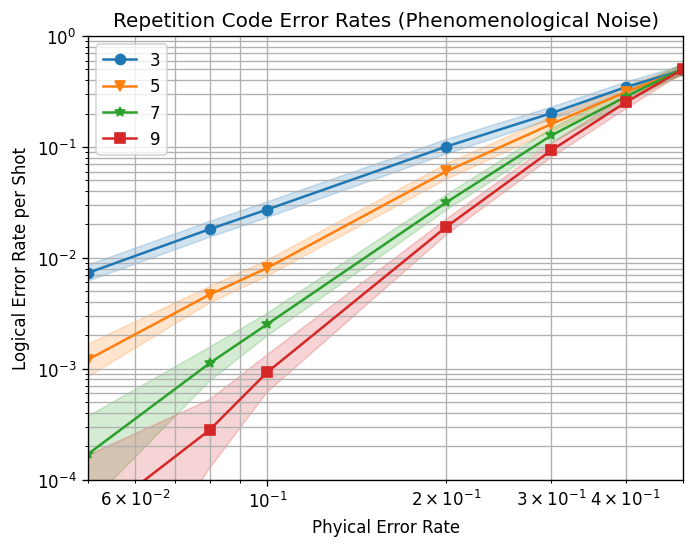

In [291]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

[TODO, 2.5pts]: Next, fix the physical bit-flip probability to $p_X = 0.01$. Assuming a cat-qubit noise bias of $10^8$, the corresponding phase-flip probability is $p_Z = 10^{-10}$. How many cat qubits are required in a repetition code to suppress the logical bit-flip probability below $10^{-10}$, so that it is comparable to the phase-flip level?

These parameter choices are loosely inspired by the following references, which provide a more detailed and rigorous analysis of error correction with cat qubits:
- [https://arxiv.org/abs/2302.06639](https://arxiv.org/abs/2302.06639)
- [https://arxiv.org/abs/2401.09541](https://arxiv.org/abs/2401.09541) 

Make a plot of logical error rate versus code distance $d$ for fixed $p_X = 0.01$. Note that the code distance $d$ is equal to the number of data qubits $n$ for the repetition code. Use `generate_rep_code_bit_flips`, which injects only bit flips, since phase flips are negligible in this regime.


Predicted distance required: d = 13


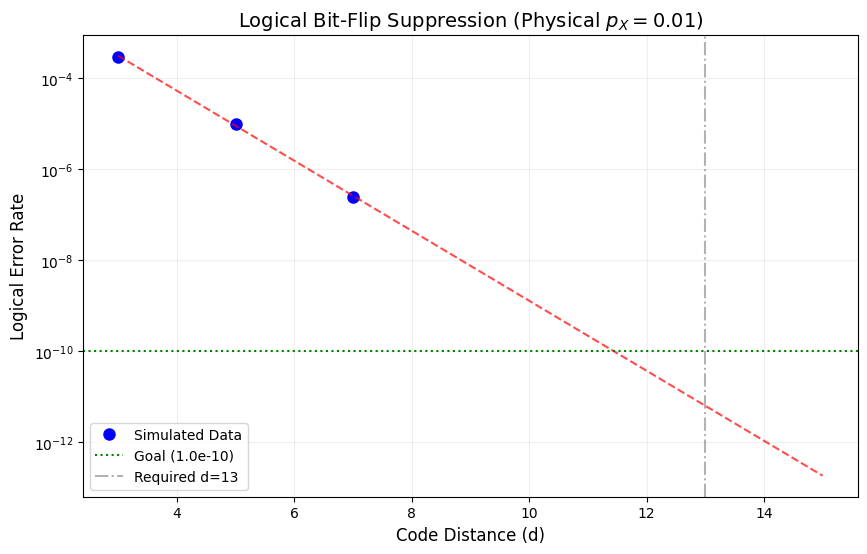

In [293]:
bit_flip_prob = 0.01
noise_bias = 1e8
goal_logical_error_rate = bit_flip_prob/noise_bias

distances = [3, 5, 7]
tasks = [
    sinter.Task(
        circuit=generate_rep_code_bit_flips(d, bit_flip_prob),
        json_metadata={'d': d},
    )
    for d in distances
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000_000, 
    max_errors=1000,      
)

xs = np.array([s.json_metadata['d'] for s in collected_stats])
ys = np.array([s.errors / s.shots for s in collected_stats])

valid = ys > 0
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs[valid], np.log10(ys[valid]))

required_d_float = (np.log10(goal_logical_error_rate) - intercept) / slope
required_d = int(np.ceil(required_d_float))
if required_d % 2 == 0: required_d += 1

print(f"Predicted distance required: d = {required_d}")

plt.figure(figsize=(10, 6))
plt.semilogy(xs, ys, 'bo', markersize=8, label='Simulated Data')

plot_xs = np.linspace(min(xs), required_d + 2, 100)
plt.semilogy(plot_xs, 10**(slope * plot_xs + intercept), 'r--', alpha=0.7)

plt.axhline(goal_logical_error_rate, color='green', linestyle=':', label=f'Goal ({goal_logical_error_rate:.1e})')
plt.axvline(required_d, color='black', linestyle='-.', alpha=0.3, label=f'Required d={required_d}')

plt.xlabel('Code Distance (d)', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title(f'Logical Bit-Flip Suppression (Physical $p_X = {bit_flip_prob}$)', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

## 4.2 - surface code benchmarks

The surface code can be viewed as a two-dimensional generalization of the repetition code that protects against both bit-flip and phase-flip errors. For this reason, many groups are pursuing surface-code architectures built from unbiased qubits (such as transmons) to suppress both types of logical errors simultaneously.

Next, we will generate an analogous plot of logical error rate versus the number of data qubits for a fixed physical depolarizing error probability of 0.001 using the surface code. From this, we will estimate how many qubits are required to reach a logical error rate of ($10^{-10}$), enabling a direct comparison with the cat-repetition results.


### 4.2.1 - surface code threshold

[TODO, 2.5pts]: First, complete `generate_surface_code_depolraizing_noise` to return a surface-code memory circuit with distance `d`, `3d` rounds, and depolarizing noise applied on data qubits. You may use Stim’s built-in surface-code memory generator and flags rather than implementing the circuit from scratch.

In [ ]:
def generate_surface_code_depolarizing_noise(d, noise):
    # SOLUTION ===
    circuit = stim.Circuit.generated(
        "surface_code:rotated_memory_z",
        rounds=3 * d,
        distance=d,
        before_round_data_depolarization=noise,
        after_clifford_depolarization=noise
    )
    # ===
    return circuit

Then, we can use stim tooling to find the threshold for the surface code.

In [212]:
import os

surface_code_tasks = [
    sinter.Task(
        circuit = generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=os.cpu_count(),
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=5_000,
    print_progress=True,
)

Starting 8 workers...
15 tasks left:
  workers    decoder eta shots_left errors_left json_metadata   
        1 pymatching <1m     996655        4729 d=3,r=9,p=0.008 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.009 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.01  
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.011 
        1 pymatching   ?    1000000        5000 d=3,r=9,p=0.012 
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.008
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.009
        1 pymatching   ?    1000000        5000 d=5,r=15,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.011
        0 pymatching ?·∞    1000000        5000 d=5,r=15,p=0.012
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.008
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.009
        0 pymatching ?·∞    1000000        5000 d=7,r=21,p=0.01 
        0 pymatching ?·∞    1000000        5000 d=7,r

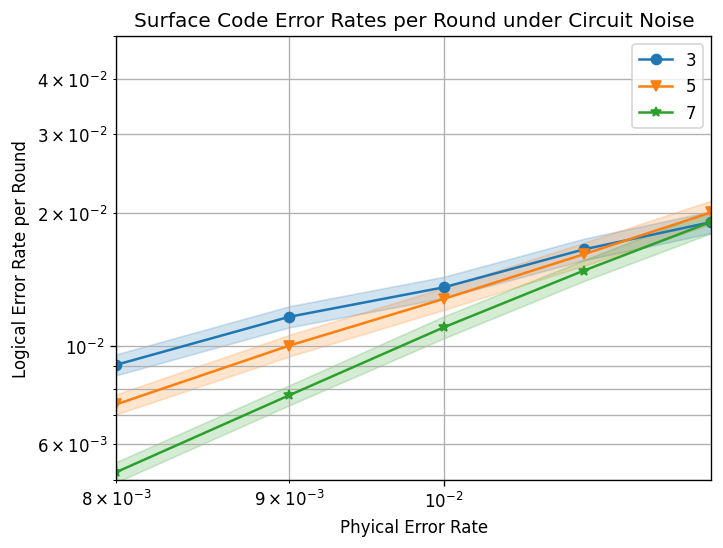

In [294]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

### 4.2.2 - estimate # of qubits for fault-tolerance

[TODO, 2.0pts]: Next, fix the depolarizing noise probability to $p = 0.001$, inspired by SOTA performance in transmon-based surface codes. As we did for the cat-repetition code, make a plot of logical error rate versus code distance $d$, which is equal to $\sqrt{n}$ for the square surface code, where $n$ is the number of data qubits. Use your `generate_surface_code_depolarizing_noise` function. The lower ylim of your plot should be `goal_logical_error_rate`. 

Predicted distance for logical error < 10^-10: d ≈ 19


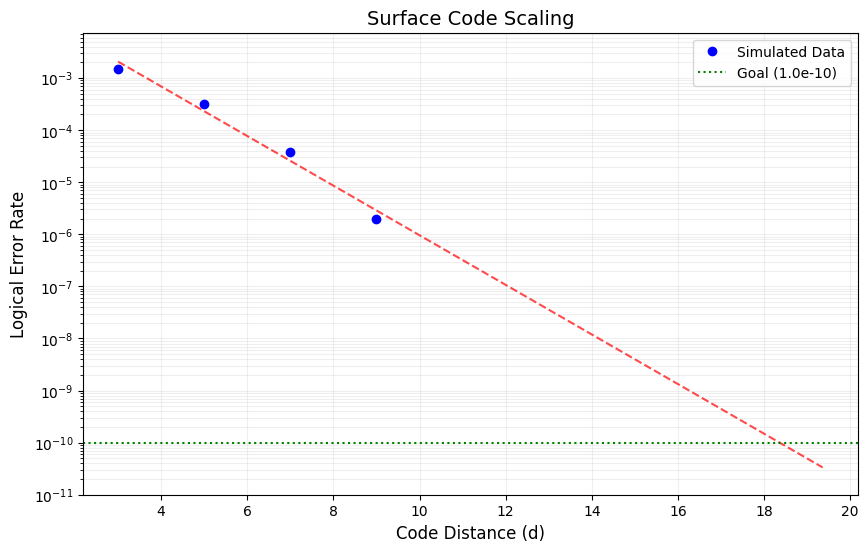

In [214]:
noise = 1e-3
goal_logical_error_rate = 1e-10

# SOLUTION ===
distances = [3, 5, 7, 9]

tasks = [
    sinter.Task(
        circuit=generate_surface_code_depolarizing_noise(d, noise),
        json_metadata={'d': d},
    )
    for d in distances
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=500,
)

xs = []
ys = []
for s in collected_stats:
    d = s.json_metadata['d']
    err_rate = s.errors / s.shots
    if err_rate > 0:
        xs.append(d)
        ys.append(err_rate)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(xs, np.log10(ys))

plt.figure(figsize=(10, 6))
plt.semilogy(xs, ys, 'bo', label='Simulated Data')
required_d = (np.log10(goal_logical_error_rate) - intercept) / slope
plot_xs = np.linspace(min(distances), required_d + 1, 100)
plt.semilogy(plot_xs, 10**(slope * plot_xs + intercept), 'r--', alpha=0.7)

# Horizontal line for the goal
plt.axhline(goal_logical_error_rate, color='green', linestyle=':', label=f'Goal ({goal_logical_error_rate:.1e})')

# Set plot limits and labels
plt.ylim(bottom=goal_logical_error_rate / 10, top=max(ys) * 5)
plt.xlabel('Code Distance (d)', fontsize=12)
plt.ylabel('Logical Error Rate', fontsize=12)
plt.title(f'Surface Code Scaling', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()

print(f"Predicted distance for logical error < 10^-10: d ≈ {int(np.ceil(required_d))}")
plt.show()

# ===

[TODO, 0.5pts]: Finally, compare the performance of the cat-repetition code to the surface code. In particular, comment on the resource requirements and potential challenges of both approaches.

# 5 - Quantum error correction inspired by classical codes

## Core Task 5.1 - Explore QEC codes inspired by classical codes

[TODO, 70pts]:

Classical error correcting codes provide a natural and powerful pathway to constructing quantum codes by directly translating classical parity checks into quantum stabilizer measurements. In particular, any linear classical code can be mapped to a quantum code that detects and corrects **bit flip (X) errors** by promoting each classical parity check into a multi-qubit ( Z )-type stabilizer. In this construction, classical codewords become logical quantum states, and the syndrome extraction process is identical in spirit to classical decoding. This approach is especially well suited for hardware with **strong noise bias**, where one error channel dominates. In our case, biased cat qubits exponentially suppress phase flip errors, leaving bit flips as the primary failure mode. As a result, we can focus entirely on X-error correction, allowing us to use a much wider and more efficient family of classical codes than would be possible for fully general quantum noise.

The final and core challenge is to choose any classical error correcting code (or family of codes), translate it into its quantum counterpart, and benchmark it against the repetition code that you already implemented. You will simulate the resulting quantum code in **Stim**, extract syndromes, perform decoding, and compare key performance metrics such as logical error rate versus number of physical qubits at a fixed physical error rate, encoding efficiency ( k/n ), the effective distance of the code and required hardware connectivity (i.e. what two-qubit gates are needed). This exploration will show how classical coding theory can be directly leveraged to design quantum codes that outperform simple repetition strategies when the noise is strongly biased.

*Optionally*, only if time permits, you may wish to demonstrate a universal, fault-tolerant set of logical gates for your code, starting with the Clifford group and extending to non-Clifford gates.


Please refer to `./2-classical-to-quantum-codes.ipynb` for a step-by-step introduction to translating a classical code into a quantum bit-flip–correcting code, along with a curated (but not exhaustive) list of classical code families to use as inspiration. You should consider this notebook required reading for the core task in this challenge.

This is an open-ended challenge, judged by the criteria specified in the `README.md` doc. 

In [215]:
import stim
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from math import comb

In [216]:
class BCH_Code:
    """
    Generic class for BCH cyclic codes.
    Parameters n, k, t, generator polynomial g_poly.
    """
    def __init__(self, n, k, t, g_poly):
        self.n = n
        self.k = k
        self.t = t
        
        # parity polynomial h(x) = (x^n - 1) / g(x)
        h_poly = self._poly_div_gf2(self.n, g_poly)
        
        # parity check matrix H
        self.num_checks = self.n - self.k
        self.H = np.zeros((self.num_checks, self.n), dtype=np.uint8)
        h_rev = np.flip(h_poly)
        for r in range(self.num_checks):
            self.H[r, r:r+len(h_rev)] = h_rev

        # syndrome table
        self.lookup = {}
        
        # 0 Errors
        self.lookup[self._key(np.zeros(self.num_checks, dtype=np.uint8))] = np.zeros(self.n, dtype=np.uint8)
        
        # 1 to t Errors
        for w in range(1, self.t + 1):
            for locs in combinations(range(self.n), w):
                e = np.zeros(self.n, dtype=np.uint8)
                e[list(locs)] = 1
                
                syn = (self.H @ e) % 2
                self.lookup[self._key(syn)] = e

    def theoretical_pL(self, p):
        """Calculates theoretical failure rate (errors > t)."""
        # Sum probabilities of k errors where k is from t+1 to n
        return sum(comb(self.n, k) * (p**k) * ((1-p)**(self.n-k)) 
                   for k in range(self.t + 1, self.n + 1))

    def _poly_div_gf2(self, n, divisor):
        """Computes (x^n + 1) / divisor in GF(2)."""
        dividend = np.zeros(n + 1, dtype=np.uint8)
        dividend[0] = 1; dividend[n] = 1
        quotient = np.zeros(n + 1, dtype=np.uint8)
        remainder = dividend.copy()
        deg_div = len(divisor) - 1
        
        while True:
            non_zeros = np.where(remainder)[0]
            if len(non_zeros) == 0: break
            deg_rem = non_zeros[-1]
            if deg_rem < deg_div: break
            
            diff = deg_rem - deg_div
            quotient[diff] = 1
            shifted_divisor = np.zeros(len(remainder), dtype=np.uint8)
            shifted_divisor[diff : diff + len(divisor)] = divisor
            remainder = (remainder + shifted_divisor) % 2
            
        last_nonzero = np.max(np.where(quotient)[0])
        return quotient[:last_nonzero+1]

    def _key(self, array):
        return array.tobytes()

In [256]:
def run_simulation(bch, probs):
    """
    Runs the simulation using the quantum circuit logic (Ancillas + CNOTs).
    """
    results = []
    theory = []
    
    print(f"{'p_phys':<10} | {'p_logical':<12} | {'theory':<12}")
    
    # INDICES SETUP
    n = bch.n
    m = bch.num_checks
    data_qubits = list(range(n))
    anc_qubits = list(range(n, n + m))

    for p in probs:
        circuit = stim.Circuit()

        circuit.append("R", data_qubits + anc_qubits)
        circuit.append("TICK")

        circuit.append("X_ERROR", data_qubits, p)
        circuit.append("TICK")
  
        for i, row in enumerate(bch.H):
            targets = []
            a = anc_qubits[i]
            for j, bit in enumerate(row):
                if bit:
                    targets += [j, a]
            
            if targets:
                circuit.append("CX", targets)
            circuit.append("TICK")
            
        circuit.append("M", anc_qubits)
        
        for i in range(m):
            circuit.append("DETECTOR", [stim.target_rec(-m + i)], [i, 0])

        circuit.append("M", data_qubits)
        
        shots = 10_000_000
        sampler = circuit.compile_sampler()
        samples = sampler.sample(shots=shots)
        
        fails = 0   
        for i in range(shots):
            full_readout = samples[i]

            syndrome_bits = full_readout[:m]
            noisy_data = full_readout[m:]
            
            syn_key = syndrome_bits.tobytes()
            
            if syn_key in bch.lookup:
                correction = bch.lookup[syn_key]
                final_state = (noisy_data + correction) % 2
                
                # Logic Failure Check
                if np.any(final_state):
                    fails += 1
            else:
                fails += 1
                
        p_sim = fails / shots
        p_th = bch.theoretical_pL(p)
        
        results.append(p_sim)
        theory.append(p_th)
        
        print(f"{p:<10.4f} | {p_sim:<12.6f} | {p_th:<12.6f}")

    return results, theory

p_phys     | p_logical    | theory      
0.0020     | 0.000004     | 0.000004    
0.0030     | 0.000013     | 0.000012    
0.0050     | 0.000052     | 0.000054    
0.0060     | 0.000097     | 0.000093    
0.0080     | 0.000218     | 0.000217    
0.0100     | 0.000418     | 0.000416    
0.0150     | 0.001318     | 0.001341    
0.0200     | 0.003008     | 0.003039    
0.0250     | 0.005639     | 0.005674    
0.0300     | 0.009398     | 0.009371    
0.0400     | 0.020319     | 0.020292    
0.0500     | 0.036148     | 0.036200    


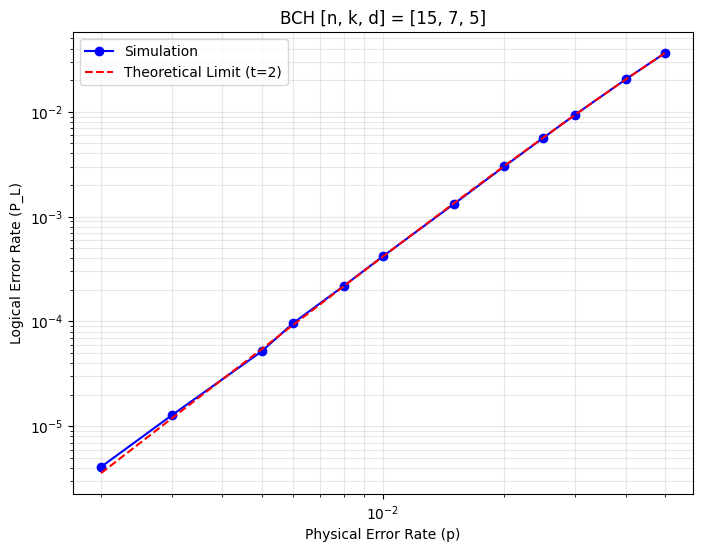

In [257]:
if __name__ == "__main__":
    N = 15
    K = 7
    T = 2
    
    # low to high
    G_POLY = np.array([1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=np.uint8) 

    my_code = BCH_Code(n=N, k=K, t=T, g_poly=G_POLY)
    probabilities = [0.002, 0.003, 0.005, 0.006, 0.008, 0.01, 0.015,  0.02, 0.025, 0.03, 0.04, 0.05]
    sim_res, th_res = run_simulation(my_code, probabilities)
    
    # plot
    plt.figure(figsize=(8, 6))
    plt.loglog(probabilities, sim_res, 'o-', color='blue', label='Simulation')
    plt.loglog(probabilities, th_res, 'r--', label=f'Theoretical Limit (t={T})')
    plt.xlabel('Physical Error Rate (p)')
    plt.ylabel('Logical Error Rate (P_L)')
    plt.title(f'BCH [n, k, d] = [{N}, {K}, {2*T+1}]')
    plt.legend()
    plt.grid(True, which="both", alpha=0.3)
    plt.show()

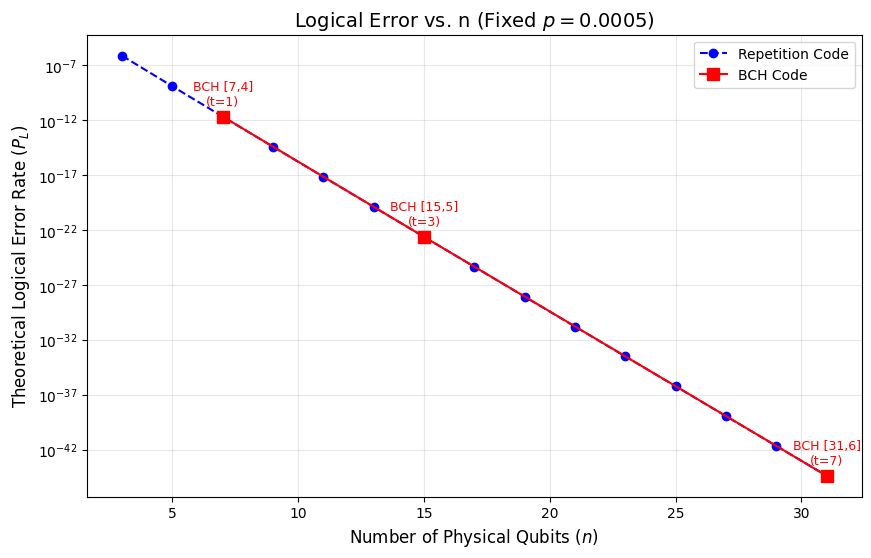

In [255]:
def theoretical_pL_bch(p, n, t):
    """
    minimum theoretical logical error rate for bch, where t is maximized
    """
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) 
               for k in range((n + 1) // 2, n + 1))

def theoretical_pL_rep(p, n):
    """
    theoretical logical error rate for repetition code
    """
    threshold = (n + 1) // 2
    return sum(comb(n, k) * (p**k) * ((1-p)**(n-k)) for k in range(threshold, n + 1))

FIXED_P = 0.0005  # 0.5% physical error rate

# repetition code
rep_ns = np.arange(3, 33, 2)
rep_y = [theoretical_pL_rep(FIXED_P, n) for n in rep_ns]

# BCH code
bch_configs = [
    (7, 1),   # BCH [7, 4, 3]  (t=1)
    (15, 3),  # BCH [15, 5, 7] (t=3)
    (31, 7)   # BCH [31, 6, 15] (t=7) 
]

bch_ns = [c[0] for c in bch_configs]
bch_y = [theoretical_pL_bch(FIXED_P, n, t) for n, t in bch_configs]

plt.figure(figsize=(10, 6))


plt.semilogy(rep_ns, rep_y, 'bo--', label='Repetition Code')
plt.semilogy(bch_ns, bch_y, 'rs-', markersize=8, label='BCH Code')

# Annotations
plt.text(7, bch_y[0] * 10, 'BCH [7,4]\n(t=1)', color='red', ha='center', fontsize=9)
plt.text(15, bch_y[1] * 10, 'BCH [15,5]\n(t=3)', color='red', ha='center', fontsize=9)
plt.text(31, bch_y[2] * 10, 'BCH [31,6]\n(t=7)', color='red', ha='center', fontsize=9)

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Logical Error Rate ($P_L$)', fontsize=12)
plt.title(f'Logical Error vs. n (Fixed $p={FIXED_P}$)', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.show()

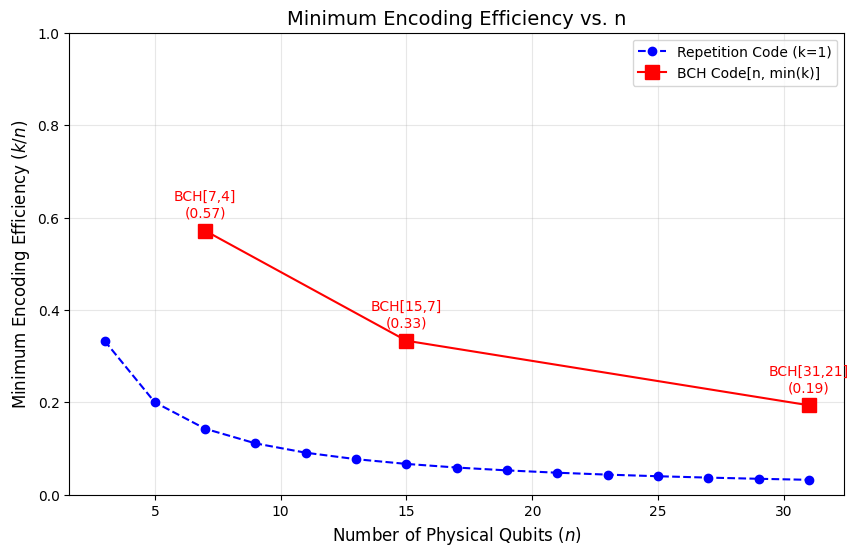

In [263]:
# Repetition Codes
rep_ns = np.arange(3, 33, 2)
rep_ks = np.ones_like(rep_ns)
rep_efficiency = rep_ks / rep_ns

# BCH Codes
bch_configs = [
    (7, 4),
    (15, 5),
    (31, 6)
]
bch_ns = [c[0] for c in bch_configs]
bch_efficiency = [c[1]/c[0] for c in bch_configs]


plt.figure(figsize=(10, 6))
plt.plot(rep_ns, rep_efficiency, 'bo--', label='Repetition Code (k=1)')

# BCH Points
plt.plot(bch_ns, bch_efficiency, 'rs-', markersize=10, label='BCH Code[n, min(k)]')

# Annotations for BCH
for n, eff, k in zip(bch_ns, bch_efficiency, [4, 7, 21]):
    plt.annotate(f'BCH[{n},{k}]\n({eff:.2f})', 
                 (n, eff), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center',
                 color='red')

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Minimum Encoding Efficiency ($k/n$)', fontsize=12)
plt.title('Minimum Encoding Efficiency vs. n', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.ylim(0, 1.0)  # Efficiency is between 0 and 1
plt.show()

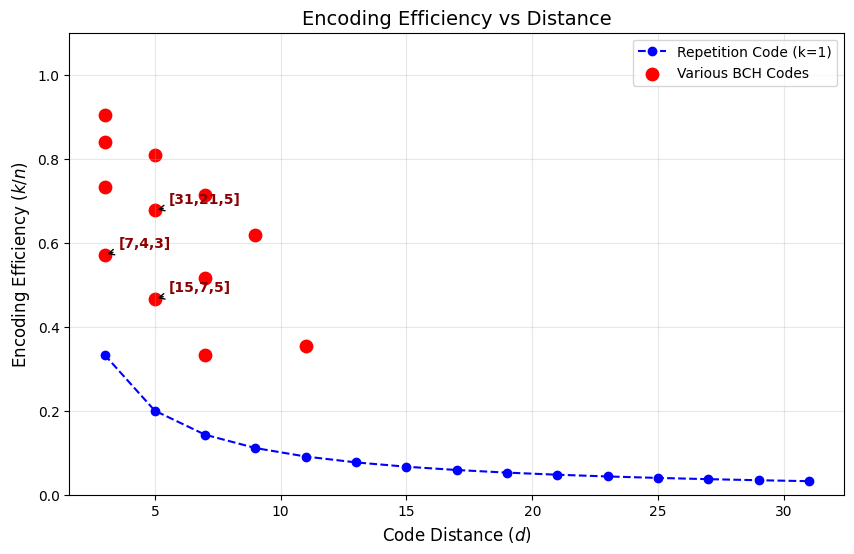

In [235]:
# 1. Repetition Codes
rep_d = np.arange(3, 32, 2)
rep_eff = 1 / rep_d

# 2. BCH Codes
bch_codes = [
    (7, 4, 3),
    (15, 11, 3), (15, 7, 5), (15, 5, 7),
    (31, 26, 3), (31, 21, 5), (31, 16, 7), (31, 11, 11),
    (63, 57, 3), (63, 51, 5), (63, 45, 7), (63, 39, 9)
]

bch_d = [c[2] for c in bch_codes]
bch_eff = [c[1]/c[0] for c in bch_codes]

# 3. Plotting
plt.figure(figsize=(10, 6))

# Repetition Line
plt.plot(rep_d, rep_eff, 'bo--', label='Repetition Code (k=1)')

# BCH Points
plt.scatter(bch_d, bch_eff, color='red', s=80, label='BCH Codes')

# Highlight the specific ones from our previous simulations
highlights = [(7,4,3), (15,7,5), (31,21,5)]
for (n, k, d) in highlights:
    plt.annotate(f'[{n},{k},{d}]', 
                 (d, k/n), 
                 xytext=(10, 5), 
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", color='black'),
                 color='darkred',
                 fontweight='bold')

plt.xlabel('Code Distance ($d$)', fontsize=12)
plt.ylabel('Encoding Efficiency ($k/n$)', fontsize=12)
plt.title('Encoding Efficiency vs Distance', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()
plt.ylim(0, 1.1)
plt.show()

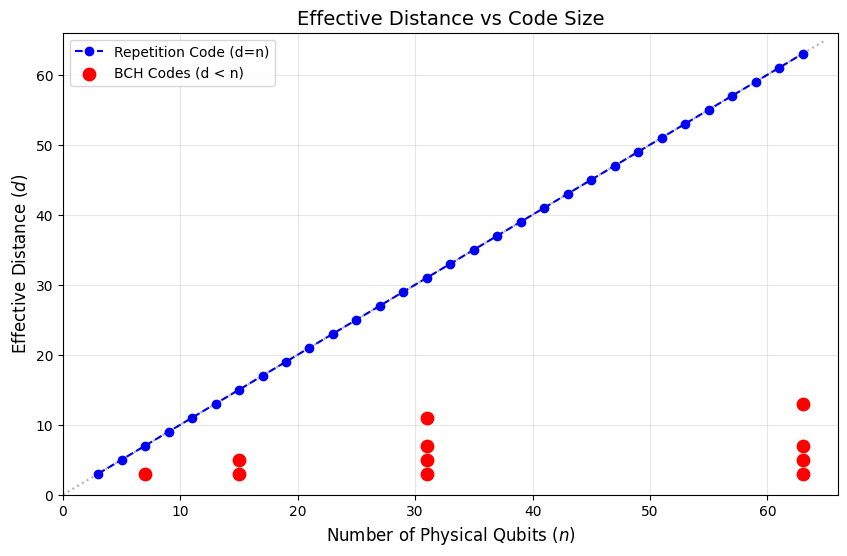

In [264]:
import matplotlib.pyplot as plt
import numpy as np

# Repetition Codes
rep_n = np.arange(3, 65, 2)
rep_d = rep_n  # d = n

# BCH Codes
bch_codes = [
    (7, 4, 3),
    (15, 11, 3),
    (15, 7, 5),
    (31, 26, 3),
    (31, 21, 5),
    (31, 16, 7),
    (31, 11, 11),
    (63, 57, 3),
    (63, 51, 5),
    (63, 45, 7),
    (63, 30, 13)
]

bch_n = [c[0] for c in bch_codes]
bch_d = [c[2] for c in bch_codes]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(rep_n, rep_d, 'bo--', label='Repetition Code (d=n)')

# BCH Points
plt.scatter(bch_n, bch_d, color='red', s=80, label='BCH Codes (d < n)', zorder=5)

plt.xlabel('Number of Physical Qubits ($n$)', fontsize=12)
plt.ylabel('Effective Distance ($d$)', fontsize=12)
plt.title('Effective Distance vs Code Size', fontsize=14)
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.plot([0, 65], [0, 65], 'k:', alpha=0.3)

plt.xlim(0, 66)
plt.ylim(0, 66)
plt.show()